In [1]:
from tqdm.auto import tqdm

# Import the .NET class library
import clr, ctypes

# Import python sys module
import sys, os

# numpy import
import numpy as np

# Import c compatible List and String
from System import *
from System.Collections.Generic import List
from System.Runtime.InteropServices import Marshal
from System.Runtime.InteropServices import GCHandle, GCHandleType


# Add needed dll references
sys.path.append(os.environ['LIGHTFIELD_ROOT'])
sys.path.append(os.environ['LIGHTFIELD_ROOT']+"\\AddInViews")
clr.AddReference('PrincetonInstruments.LightFieldViewV5')
clr.AddReference('PrincetonInstruments.LightField.AutomationV5')
clr.AddReference('PrincetonInstruments.LightFieldAddInSupportServices')

# PI imports
from PrincetonInstruments.LightField.Automation import *
from PrincetonInstruments.LightField.AddIns import *


import nidaqmx
import numpy as np
import matplotlib.pyplot as plt

def set_value(setting, value):    
    # Check for existence before setting
    # gain, adc rate, or adc quality
    if experiment.Exists(setting):
        experiment.SetValue(setting, value)

def device_found():
    # Find connected device
    for device in experiment.ExperimentDevices:
        if (device.Type == DeviceType.Camera):
            return True
     
    # If connected device is not a camera inform the user
    print("Camera not found. Please add a camera and try again.")
    return False  

def convert_buffer(net_array, image_format):
    src_hndl = GCHandle.Alloc(net_array, GCHandleType.Pinned)
    try:
        src_ptr = src_hndl.AddrOfPinnedObject().ToInt64()

        # Possible data types returned from acquisition
        if (image_format==ImageDataFormat.MonochromeUnsigned16):
            buf_type = ctypes.c_ushort*len(net_array)
        elif (image_format==ImageDataFormat.MonochromeUnsigned32):
            buf_type = ctypes.c_uint*len(net_array)
        elif (image_format==ImageDataFormat.MonochromeFloating32):
            buf_type = ctypes.c_float*len(net_array)
                    
        cbuf = buf_type.from_address(src_ptr)
        resultArray = np.frombuffer(cbuf, dtype=cbuf._type_)

    # Free the handle 
    finally:        
        if src_hndl.IsAllocated: src_hndl.Free()
        
    # Make a copy of the buffer
    return np.copy(resultArray)


c:\users\raman\miniconda3\envs\control\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The module was found, but not in a referenced namespace.
Implicit loading is deprecated. Please use clr.AddReference('System.Collections').
  if sys.path[0] == '':


In [2]:
AOchannels = [0,1]
sampleRate = 100000
numSamplesPerChannel = 50
sampleClockSource = 'PFI0'
devName = 'Dev1'

In [3]:
shutter_task = nidaqmx.Task()
shutter_chan = shutter_task.do_channels.add_do_chan('Dev1/port0/line0')

In [4]:
# galvo mirror
galvo = nidaqmx.Task('galvoAO')
channels = ['Dev1/ao0', 'Dev1/ao1']
galvo.ao_channels.add_ao_voltage_chan(channels[0],'x', min_val=-10, max_val=10)
galvo.ao_channels.add_ao_voltage_chan(channels[1],'y', min_val=-10, max_val=10)

#laser shutter
shutter = nidaqmx.Task('shutterDO')
shutter_chan = shutter.do_channels.add_do_chan('Dev1/port0/line0')


### Setup camera

In [5]:
# Create the LightField Application (true for visible)
# The 2nd parameter forces LF to load with no experiment 
auto = Automation(True, List[String]())
experiment = auto.LightFieldApplication.Experiment
experiment.Load('Pixis')
def set_value(setting, value):    
    # Check for existence before setting
    # gain, adc rate, or adc quality
    if experiment.Exists(setting):
        experiment.SetValue(setting, value)



In [6]:
set_value(CameraSettings.ShutterTimingExposureTime, 20.0)


## Setup scope control


In [7]:
from pycromanager import Bridge

bridge = Bridge()
core = bridge.get_core()

In [8]:
def close_all():
    auto.Dispose()
    galvo.close()
    shutter.close()

In [9]:
shutter.write(False)

1

In [13]:
core.snap_image()

In [14]:
tag_im = core.get_tagged_image()

In [15]:
pixels = np.reshape(tagged_image.pix,
                                        newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])

NameError: name 'tagged_image' is not defined

In [16]:
def snap_image():
    """
    wrapper around core.snap_image to return a reshaped numpy array
    """
    core.snap_image()
    tagged_image = core.get_tagged_image()
    return np.reshape(tagged_image.pix, newshape=[tagged_image.tags['Height'], tagged_image.tags['Width']])

In [20]:
pix = snap_image()

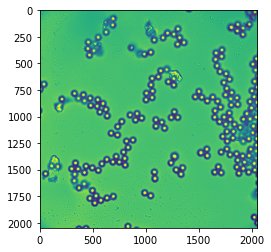

In [21]:
plt.imshow(pix)

In [22]:
experiment.Preview()

In [119]:
class shutter_controller:
    def __init__(self, shutter, open_):
        self.shutter = shutter
        self.open_ = open_
    def __enter__(self):
        self.shutter.write(self.open_)
    def __exit__(self,  *exc):
        self.shutter.write(not self.open_)
    def __call__(self):
        self.shutter.write(self.open_)
open_shutter = shutter_controller(shutter, True)
close_shutter = shutter_controller(shutter, False)

In [115]:
# def open_shutter():
#     return shutter.write(True)
# def close_shutter():
#     return shutter.write(False)
shutter.open = open_shutter
shutter.close = close_shutter

In [116]:
shutter.open()

In [112]:
shutter.write(not True)

1

In [43]:
experiment.Stop()

In [28]:
experiment.Preview()
shutter.open()

1

In [29]:
shutter.close()

1

In [31]:
galvo.write([0,0])

1

In [32]:
core.get_position()

4925.12

In [33]:
core.set_position(4925)

In [39]:
cur_z = core.get_position()
steps = np.linspace(-10,10,10)

In [40]:
import time

In [42]:
for s in steps:
    core.set_position(cur_z + s)
    time.sleep(1)
core.set_position(cur_z)

In [81]:
def convert_capture(cap, spectrum_length = 1340):
    """
    parameters
    ----------
    cap : experiment.Capture
    spectrum_length : int
        1340 for current setup

    returns
    -------
    numpy array
        rows are samples
    """
    arr = np.zeros([cap.Frames, 1340], dtype=np.uint16)
    for i in range(cap.Frames):
        frame = cap.GetFrame(0,i)
        arr[i]  = convert_buffer(frame.GetData(), frame.Format)
    return arr
def set_rm_exposure(exposure_time):
    """
    sets the exposure time for raman
    parameters
    ----------
    exposure_time : float
        camera exposure in milliseconds
    """
    return set_value(CameraSettings.ShutterTimingExposureTime, exposure_time)


In [126]:
steps2 = np.linspace(-10,10,10)
z_stack2 = []
set_rm_exposure(750)
with open_shutter:
    for s in tqdm(steps2):
        core.set_position(cur_z + s)
        time.sleep(1)
        z_stack2.append(convert_capture(experiment.Capture(1)))

core.set_position(cur_z)

In [127]:
stack = np.asarray(z_stack).squeeze()
stack2 = np.asarray(z_stack2).squeeze()

In [128]:
stack.shape

(100, 1340)

Text(0, 0.5, '664 peak')

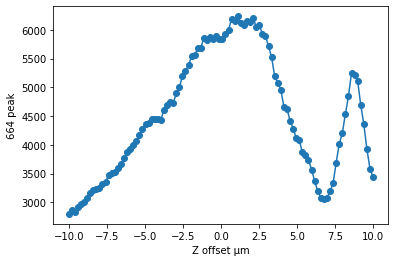

In [129]:
plt.plot(steps, stack[:,664],'o-')
plt.xlabel('Z offset μm')
plt.ylabel('664 peak')

Text(0, 0.5, '664 peak')

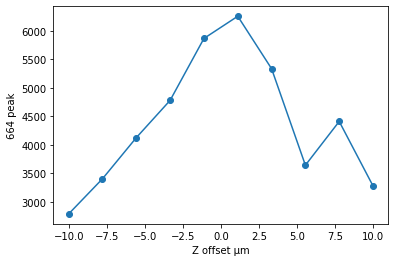

In [130]:
plt.plot(steps2, stack2[:,664],'o-')
plt.xlabel('Z offset μm')
plt.ylabel('664 peak')

In [123]:
with open_shutter:
    opened = convert_capture(experiment.Capture(1))[0]

In [124]:
with close_shutter:
    closed = convert_capture(experiment.Capture(1))[0]

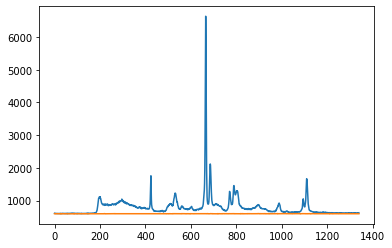

In [125]:
plt.plot(opened)
plt.plot(closed)

In [131]:
experiment.Preview()

In [132]:
experiment.Stop()

In [133]:
close_all()